# NN4: Rozwiązywanie zadania klasyfikacji

#### Magdalena Jeczeń

Wczytywanie danych

In [63]:
import numpy as np
import pandas as pd
data = pd.read_csv('./mio1/classification/rings3-regular-training.csv')
X_train_r3_r = np.array([data.x, data.y]).transpose()
y_train_r3_r = np.array(data.c)
data = pd.read_csv('./mio1/classification/rings3-regular-test.csv')
X_test_r3_r = np.array([data.x, data.y]).transpose()
y_test_r3_r = np.array(data.c)
data = pd.read_csv('./mio1/classification/easy-training.csv')
X_train_e= np.array([data.x, data.y]).transpose()
y_train_e = np.array(data.c)
data = pd.read_csv('./mio1/classification/easy-test.csv')
X_test_e= np.array([data.x, data.y]).transpose()
y_test_e = np.array(data.c)
data = pd.read_csv('./mio1/classification/xor3-training.csv')
X_train_x_3 = np.array([data.x, data.y]).transpose()
y_train_x_3 = np.array(data.c)
data = pd.read_csv('./mio1/classification/xor3-test.csv')
X_test_x_3 = np.array([data.x, data.y]).transpose()
y_test_x_3  = np.array(data.c)

inne funkcje

In [4]:
def one_hot_encoding(y):
    unique_classes = np.unique(y)
    y_encoded = np.zeros((len(y), len(unique_classes)))

    for i, c in enumerate(y):
        j = np.where(unique_classes == c)[0][0]
        y_encoded[i, j] = 1

    return y_encoded

In [85]:
def one_hot_decoding(y_encoded):
    num_classes = y_encoded.shape[1]
    decoded_values = np.zeros(y_encoded.shape[0], dtype=int)
    for i, encoded_row in enumerate(y_encoded):
        index = np.where(encoded_row == 1)[0][0]
        decoded_values[i] = index

    return decoded_values


In [5]:
import matplotlib.pyplot as plt
def plot_scatter_with_classes(X, y):

    classes = np.unique(y)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  
    
    for idx, class_label in enumerate(classes):
        class_data = X[y == class_label]
        plt.scatter(class_data[:, 0], class_data[:, 1], color=colors[idx % len(colors)], label=f'Class {class_label}')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Scatter Plot with Classes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [50]:
def plot_multiple_costs(costs_list):
    plt.figure(figsize=(10, 6))
    
    for cost_df, label in costs_list:
        plt.plot(cost_df['Epoch'], cost_df['Cost_Train'], label=label)

    plt.xlabel('Epoch')
    plt.ylabel('Cost Train')
    plt.title('Cost Train Comparison')
    plt.legend()
    plt.show()

In [51]:
def plot_multiple_costs_log(costs_list):
    plt.figure(figsize=(10, 6))
    
    for cost_df, label in costs_list:
        plt.plot(cost_df['Epoch'], cost_df['Cost_Train'], label=label)

    plt.xlabel('Epoch')
    plt.ylabel('Cost Train')
    plt.title('Cost Train Comparison with logaritmic mse values')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()
    plt.show()

In [52]:
def make_df_of_costs(cost_history):
    return pd.DataFrame(cost_history, columns=['Epoch', 'Cost_Train'])

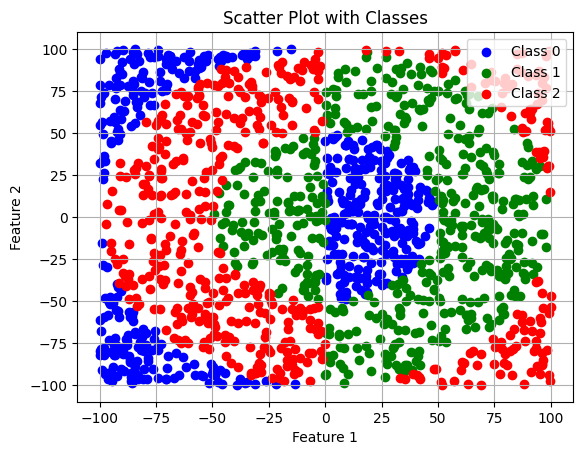

In [64]:
plot_scatter_with_classes(X_train_r3_r, y_train_r3_r)

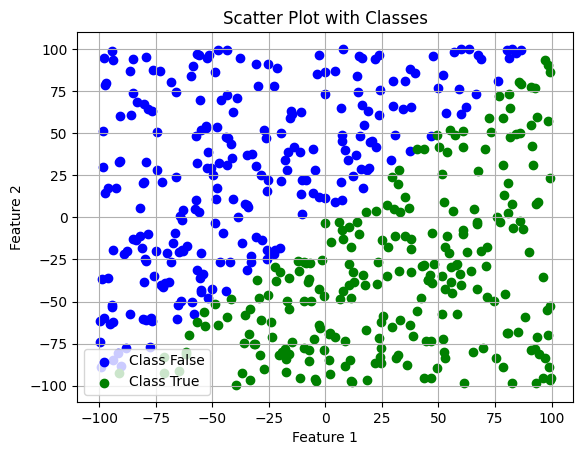

In [7]:
plot_scatter_with_classes(X_train_e, y_train_e)

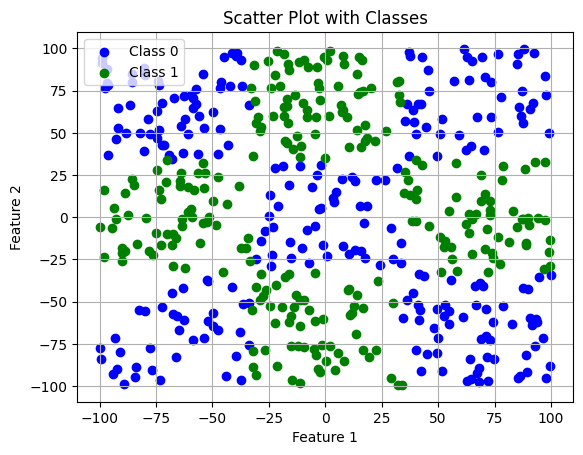

In [8]:
plot_scatter_with_classes(X_train_x_3, y_train_x_3)

In [68]:
y_train_e_enc = one_hot_encoding(y_train_e)
y_train_r3_r_enc = one_hot_encoding(y_train_r3_r)
y_train_x_3_enc = one_hot_encoding(y_train_x_3)
y_test_e_enc = one_hot_encoding(y_test_e)
y_test_r3_r_enc = one_hot_encoding(y_test_r3_r)
y_test_x_3_enc = one_hot_encoding(y_test_x_3)

Sieć neuronowa

In [201]:
class Network(object):
    def __init__(self, layers_sizes, activation_function_type, problem = "regression", last_layer_function = "linear"):
        self.problem = problem
        self.last_layer_function = last_layer_function
        
        self.weights = None
        self.biases = None
        self.weights_0 = None
        self.biases_0 = None
        
        self.means_X = []
        self.means_Y = []
        self.stds_Y = []
        self.stds_X = []
        
        self.mean_X = None
        self.mean_Y = None
        self.std_Y = None
        self.std_X = None
    
        
        self.sizes_in = layers_sizes[:-1]
        self.sizes_out = layers_sizes[1:]
        
        self.a = None
        self.z = None
        
        self.activation_function_type = activation_function_type
        
        self.mse_train = None
        
        self.cost_history = []
        
        self.velocity_weight = None
        self.velocity_bias = None
        
        self.mean_square_weight = None
        self.mean_square_bias = None
        
    def __activation_function(self, x):
        if self.activation_function_type == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))

    def __activation_function_derivative(self, x):
        if self.activation_function_type == "sigmoid":
            return self.__activation_function(np.array(x)) * (1-self.__activation_function(np.array(x)))
    
    def __last_layer_funcion(self, x):
        if self.last_layer_function == "linear":
            return x
        elif self.last_layer_function == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        elif self.last_layer_function == "softmax":
            l = np.exp(x)
            m = np.sum(l,axis = 1, keepdims=True)
            s = l/m
            return s
        
    
    
    def generate_weights(self, method = 'uniform'):
        if method == 'uniform':
            self.weights_0 = [np.random.rand(size_in,size_out) for (size_in,size_out) in zip(self.sizes_in,self.sizes_out)]
        if method == 'he':
            self.weights_0 = [np.random.normal(0,np.sqrt(2/(insi+outi)),size = (insi,outi)) for (insi,outi) in zip(self.sizes_in,self.sizes_out)]
            
        self.weights = self.weights_0.copy()
        
        self.z = [None]*len(self.weights)
        self.a = [None]*len(self.weights)
            
    def generate_biases(self, method = 'zeros'):
        if method == 'zeros':
            self.biases_0 = [np.zeros(size_out) for size_out in self.sizes_out]
            
        self.biases = self.biases_0.copy()
        
    def set_custom_weights(self, custom_weights):
        self.weights_0 = custom_weights.copy()
        self.weights = self.weights_0.copy()   
        
    
    def get_normalization_parameters(self,X,Y):
        for i in range(X.shape[1]):
            mean = np.mean(X[:,i])
            std = np.std(X[:,i])
            self.means_X.append(mean)
            self.stds_X.append(std)
            
        if self.problem == "regression":
            for i in range(Y.shape[1]):
                mean = np.mean(Y[:,i])
                std = np.std(Y[:,i])
                self.means_Y.append(mean)
                self.stds_Y.append(std)
            
        
    def normalize_X(self,X):
        X_norm = X.copy()
        for i in range(X.shape[1]):
            X_norm[:,i] = (X[:,i] - self.means_X[i])/self.stds_X[i]
            
        return X_norm
    
    def denormalize_Y(self, Y_pred):
        Y_d = Y_pred.copy()
        for i in range(Y_pred.shape[1]):
            Y_d[:,i] = Y_pred[:,i]*self.stds_Y[i] + self.means_Y[i]
        return Y_d
    
    def feedforward(self, X):
        #print("X: ", X)
        #layer = np.row_stack(self.normalize_X(X))
        layer = self.normalize_X(X)
        #print("layer ( X normalized ): ", layer)
        self.z[0] = layer
        for i in range(len(self.weights) - 1):
            self.a[i] = layer
            layer = layer@self.weights[i] + self.biases[i]
            self.z[i+1] = layer
            layer = self.__activation_function(layer)
    
        self.a[-1] = layer
        Y_pred = None 
        
        if self.problem == "classification":
            Y_pred = self.__last_layer_funcion(layer@self.weights[len(self.weights) - 1]+self.biases[len(self.weights) - 1])
        
        elif self.problem == "regression":
            Y_pred_normalized = (layer@self.weights[len(self.weights) - 1] + self.biases[len(self.weights) - 1])
            Y_pred_denormalized = self.denormalize_Y(np.hstack(Y_pred_normalized))
            Y_pred = Y_pred_denormalized
        
        return Y_pred
    
    def MSE(self, X, Y):
        return np.mean((self.feedforward(X) - Y) ** 2)
    
    
    def Fscore(self, X, Y):
        y_pred = self.feedforward(X)
        classes = np.argmax(y_pred, axis=1)
        y_pred_one_hot = np.zeros(Y.shape)
        y_pred_one_hot[np.arange(len(y_pred_one_hot)), classes] = 1
        y_pred_one_hot = y_pred_one_hot.astype(int).transpose()
        Y = Y.astype(int).transpose()
        result = np.zeros(len(Y))
        for i in range(len(Y)):
            tp = np.count_nonzero(y_pred_one_hot[i] & Y[i])  
            fp = np.count_nonzero(y_pred_one_hot[i] & (1 - Y[i]))  
            fn = np.count_nonzero((1 - y_pred_one_hot[i]) & Y[i])  
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            if precision + recall == 0:
                result[i] = 0
            else:
                result[i] = 2 * (precision * recall) / (precision + recall)
        return result
    
    
    def FScore_mean(self, Fscore):
        return np.mean(Fscore)
    
    def backprop(self,X,Y):
        n = len(self.weights)
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta = (self.feedforward(X)-Y)/len(X)
        for i in range(1,n+1):
                delta_b[-i] = np.sum(delta,axis = 0)
                delta_w[-i] = (self.a[-i].transpose())@delta
                delta = (delta@(self.weights[-i].transpose()))*self.__activation_function_derivative(self.z[-i])
        return delta_w, delta_b
   
    def Moment(self, delta_w, delta_b, alpha):
        self.velocity_bias = [alpha*prev_vel_bias + db for (prev_vel_bias,db) in zip(self.velocity_bias,delta_b)]
        self.velocity_weight = [alpha*prev_vel_weight + dw for (prev_vel_weight,dw) in zip(self.velocity_weight,delta_w)]
        return self.velocity_weight, self.velocity_bias
   
    def RMSProp(self, delta_w, delta_b, alpha):
        self.mean_square_weight = [alpha*prev_mean_sq_w + (1-alpha)*np.square(dw) for (prev_mean_sq_w,dw) in zip(self.mean_square_weight,delta_w)]
        self.mean_square_bias = [alpha*prev_mean_sq_b + (1-alpha)*np.square(db) for (prev_mean_sq_b,db) in zip(self.mean_square_bias,delta_b)]
        
        delta_w_divided = [np.divide(dw,np.sqrt(mean_sq_w)+0.000001) for (mean_sq_w,dw) in zip(self.mean_square_weight,delta_w)]
        delta_b_divided = [np.divide(db,np.sqrt(mean_sq_b)+0.000001) for (mean_sq_b,db) in zip(self.mean_square_bias,delta_b)]
        return delta_w_divided, delta_b_divided
   
    def train(self,X,Y,batch_size, eta, epochs, method = "gradient", alpha = 0.9, X_test=None, Y_test=None, shuffle = False):
        n = len(X)
        self.get_normalization_parameters(X,Y)
        self.mse_train= [None]*epochs
        
        self.velocity_weight = [np.zeros(w.shape) for w in self.weights]
        self.velocity_bias= [np.zeros(b.shape) for b in self.biases]
        self.mean_square_weight = [np.zeros(w.shape) for w in self.weights]
        self.mean_square_bias = [np.zeros(b.shape) for b in self.biases]
        
        for epoch in range(epochs):
            mini_batches = list(range(n))
            if shuffle:
                np.random.shuffle(mini_batches)
            for i in range(0,n,batch_size):
                mini_batch = mini_batches[i:i+batch_size]
                delta_w, delta_b = self.backprop(X[mini_batch],Y[mini_batch])
                if method == "moment":
                    delta_w, delta_b = self.Moment(delta_w, delta_b, alpha)
                elif method == "RMSProp":
                    delta_w, delta_b = self.RMSProp(delta_w,delta_b,alpha)
                
                self.weights = [w- eta*dw for (w,dw) in zip(self.weights,delta_w)]
                self.biases = [b- eta*db for (b,db) in zip(self.biases,delta_b)] 
            
            if self.problem == "regression":
                mse = self.MSE(X, Y)
                self.cost_history.append((epoch, mse))
                print("Epoch {0} complete, mse: {1}".format(epoch, mse))
                
            
            elif self.problem == "classification":
                Fscore = self.Fscore(X,Y)
                Fscore_mean = self.FScore_mean(Fscore)
                self.cost_history.append((epoch, Fscore_mean))
                print("Epoch {0} complete, Fscore: {1}, Fscore_mean: {2}".format(epoch, Fscore, Fscore_mean))
                
        if self.problem == "regression":
            if X_test is not None and Y_test is not None:
                print("Mse for test: ", self.MSE(X_test, Y_test))
        
        elif self.problem == "classification":
            if X_test is not None and Y_test is not None:
                Fscore_test = self.Fscore(X_test, Y_test)
                print("Fscore for test: {0}, Fscore_mean for test: {1}".format(Fscore_test ,self.FScore_mean(Fscore_test)))
        
            
        return None

##### Zbiór easy

In [202]:
net_e_soft = Network([2,5,2], "sigmoid", problem = "classification", last_layer_function="softmax")

In [203]:
net_e_soft.generate_weights("he")

In [204]:
net_e_soft.generate_biases("zeros")

In [205]:
net_e_soft.train(X_train_e, y_train_e_enc, 10, 0.001, 200, shuffle=False, X_test = X_test_e, Y_test=y_test_e_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 1 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 2 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 3 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 4 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 5 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 6 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 7 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 8 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 9 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 10 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 11 complete, Fscore: [0.10606061 0.67934783], Fscore_mean: 0.3927042160737813
Ep

In [211]:
print("F score dla zbioru easy dla zbioru treningowego:", 0.9939999759999041)
print("F score dla zbioru easy dla zbioru testowego: ", 0.9919998719979519)

F score dla zbioru easy dla zbioru treningowego: 0.9939999759999041
F score dla zbioru easy dla zbioru testowego:  0.9919998719979519


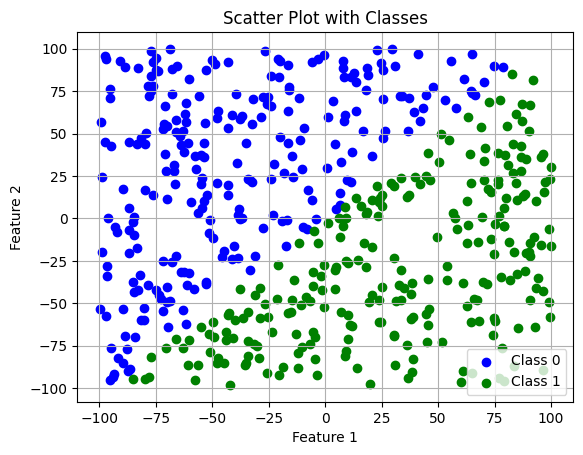

In [212]:
y_pred = net_e_soft.feedforward(X_test_e)
classes = np.argmax(y_pred, axis=1)
y_pred = classes
plot_scatter_with_classes(X_test_e, y_pred)

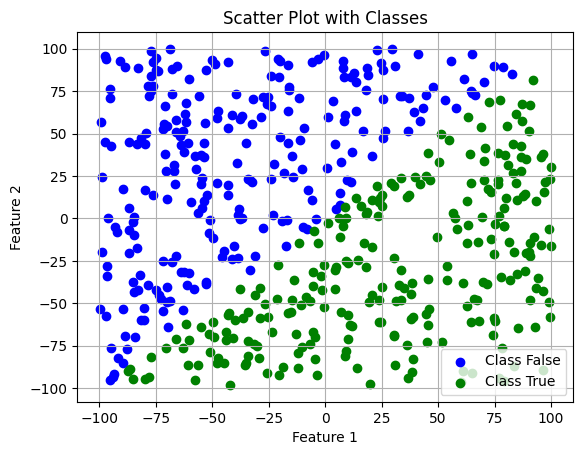

In [213]:
plot_scatter_with_classes(X_test_e, y_test_e)

Dane te, jak sama ich nazwa wskazuje są proste do wytrenowania - model szybko osiąga wysoki F score

In [206]:
net_e_sigm = Network([2,5,2], "sigmoid", problem = "classification", last_layer_function="sigmoid")

In [207]:
net_e_sigm.generate_weights("he")
net_e_sigm.generate_biases("zeros")

In [208]:
net_e_sigm.train(X_train_e, y_train_e_enc, 10, 0.001, 200, shuffle=False, X_test = X_test_e, Y_test=y_test_e_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 1 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 2 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 3 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 4 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 5 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 6 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 7 complete, Fscore: [0.08429119 0.67658999], Fscore_mean: 0.3804405871038319
Epoch 8 complete, Fscore: [0.23943662 0.69832402], Fscore_mean: 0.4688803210323393
Epoch 9 complete, Fscore: [0.29931973 0.7082153 ], Fscore_mean: 0.5037675126707908
Epoch 10 complete, Fscore: [0.41772152 0.73099415], Fscore_mean: 0.5743578355170627
Epoch 11 complete, Fscore: [0.47094801 0.74294205], Fscore_mean: 0.6069450313762377
Ep

In [209]:
cost_soft = make_df_of_costs(net_e_soft.cost_history)
cost_sigm = make_df_of_costs(net_e_sigm.cost_history)
cost_list = [(cost_soft, 'Softmax'), (cost_sigm, 'Sigmoid')]

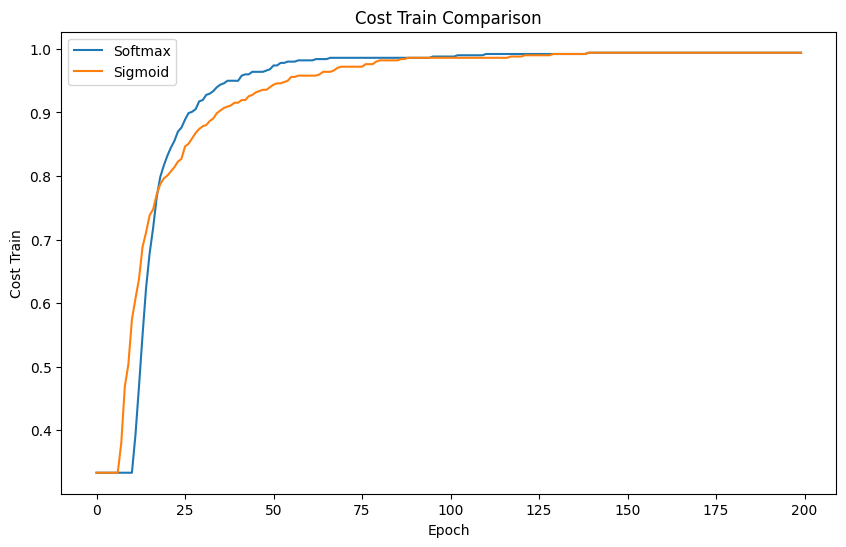

In [210]:
plot_multiple_costs(cost_list)

Jak widać w przypadku tych prostych danych na samym początku lepiej radzi sobie model z funkcją sigmoidalną na końcu. Jednak szybko się to zmienia i lepiej zbiega model z funkcją softmax na końcu. Zatem dla tych danych lepiej radzi sobie funkcja softmax na końcu.

##### Zbiór rings3-regular

In [82]:
net_r3_3_soft = Network([2,10,10,3], "sigmoid", problem = "classification", last_layer_function="softmax")

In [83]:
net_r3_3_soft.generate_weights("he")
net_r3_3_soft.generate_biases("zeros")

In [84]:
net_r3_3_soft.train(X_train_r3_r, y_train_r3_r_enc, 100, 0.01, 1000, shuffle=False, X_test = X_test_r3_r, Y_test=y_test_r3_r_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 1 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 2 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 3 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 4 complete, Fscore: [0.         0.18987342 0.45824411], Fscore_mean: 0.21603917635685177
Epoch 5 complete, Fscore: [0.         0.42894057 0.45422943], Fscore_mean: 0.294390000229554
Epoch 6 complete, Fscore: [0.         0.53317811 0.46313224], Fscore_mean: 0.3321034501757803
Epoch 7 complete, Fscore: [0.         0.55543595 0.47740293], Fscore_mean: 0.34427962690284547
Epoch 8 complete, Fscore: [0.         0.57       0.49333333], Fscore_mean: 0.3544444444444445
Epoch 9 complete, Fscore: [0.         0.57829011 0.50445511], Fscore_mean: 0.36091507063492534
Epoch 10 complete, Fscore: [0.         0.58976744 0.51508772], Fscore_mean: 0.36828505371957015
Epoch 11 complete, Fscore: [0.         0.5

In [98]:
print("F score dla zbioru rings3-regular dla zbioru treningowego:", 0.8762070396818249)
print("F score dla zbioru rings3-regular dla zbioru testowego: ", 0.8682398177560771)

F score dla zbioru rings3-regular dla zbioru treningowego: 0.8762070396818249
F score dla zbioru rings3-regular dla zbioru testowego:  0.8682398177560771


In [95]:
y_pred = net_r3_3_soft.feedforward(X_test_r3_r)
classes = np.argmax(y_pred, axis = 1)
y_pred = classes

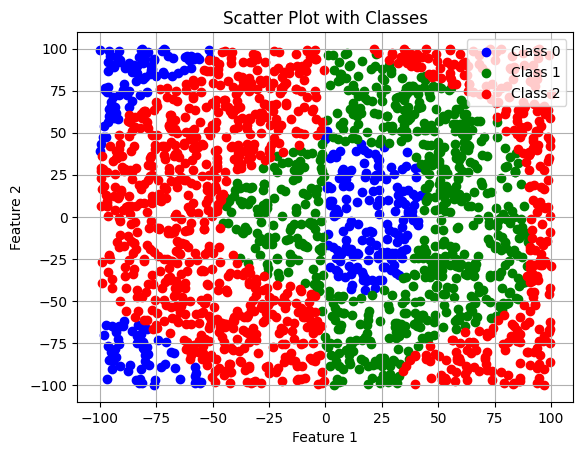

In [96]:
plot_scatter_with_classes(X_test_r3_r, y_pred)

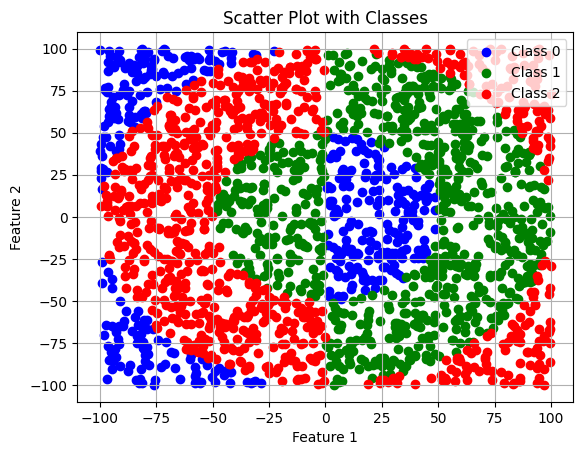

In [97]:
plot_scatter_with_classes(X_test_r3_r, y_test_r3_r)

In [99]:
net_r3_3_sigm = Network([2, 10, 10, 3], "sigmoid", problem="classification", last_layer_function="sigmoid")
net_r3_3_sigm.generate_weights("he")
net_r3_3_sigm.generate_biases("zeros")


In [100]:
net_r3_3_sigm.train(X_train_r3_r, y_train_r3_r_enc, 100, 0.01, 1000, shuffle=False, X_test = X_test_r3_r, Y_test=y_test_r3_r_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.  0.5 0. ], Fscore_mean: 0.16666666666666666
Epoch 1 complete, Fscore: [0.  0.5 0. ], Fscore_mean: 0.16666666666666666
Epoch 2 complete, Fscore: [0.         0.54676259 0.49579832], Fscore_mean: 0.34752030308526294
Epoch 3 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 4 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 5 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 6 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 7 complete, Fscore: [0.  0.  0.5], Fscore_mean: 0.16666666666666666
Epoch 8 complete, Fscore: [0.         0.03272727 0.47076923], Fscore_mean: 0.16783216783216784
Epoch 9 complete, Fscore: [0.         0.19354839 0.46808511], Fscore_mean: 0.22054449782658433
Epoch 10 complete, Fscore: [0.         0.37653479 0.45840407], Fscore_mean: 0.27831295441437726
Epoch 11 complete, Fscore: [0.         0.49135802 0.46035503], Fscore_mean: 0.3172376847590523
Epoch 

In [101]:
cost_soft = make_df_of_costs(net_r3_3_soft.cost_history)
cost_sigm = make_df_of_costs(net_r3_3_sigm.cost_history)
cost_list = [(cost_soft, 'Softmax'), (cost_sigm, 'Sigmoid')]

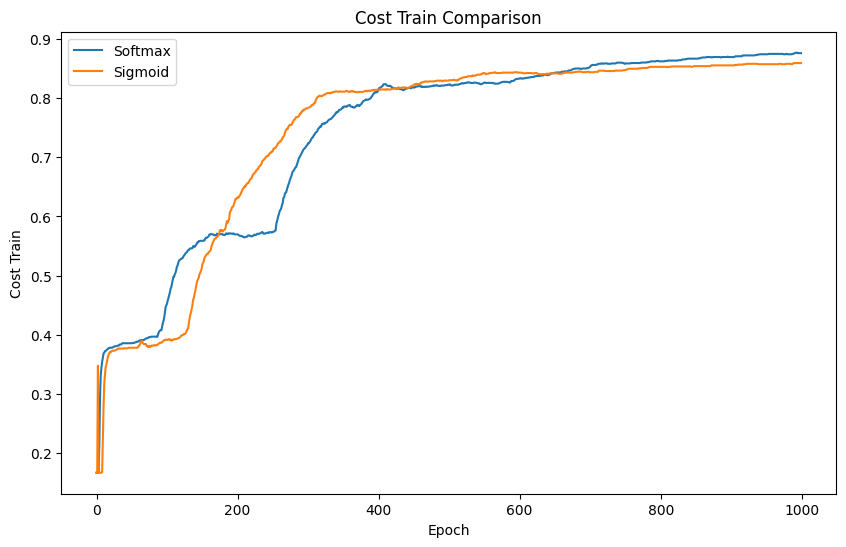

In [102]:
plot_multiple_costs(cost_list)

Jak widać na wykresie, modele wymieniają się wczasie - w pewnym zakresie epok lepiej radzi sobie model z funkcją sigmoidalną na końcu, w innym zakresie - z funkcją softmax. Jednak na końcu trenowania lepiej radzi sobie model z funkcją softmax.

##### Zbiór xor3

In [161]:
net_x_3_soft = Network([2,10,10,2], "sigmoid", problem="classification", last_layer_function="softmax")
net_x_3_soft.generate_weights("he")
net_x_3_soft.generate_biases("zeros")

In [162]:
net_x_3_soft.train(X_train_x_3, y_train_x_3_enc, 100, 0.004, 5000, shuffle=True, X_test = X_test_x_3, Y_test=y_test_x_3_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 1 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 2 complete, Fscore: [0.08429119 0.67658999], Fscore_mean: 0.38044058710383194
Epoch 3 complete, Fscore: [0.28493151 0.58897638], Fscore_mean: 0.43695394240103547
Epoch 4 complete, Fscore: [0.63945578 0.        ], Fscore_mean: 0.3197278911564626
Epoch 5 complete, Fscore: [0.34285714 0.45137615], Fscore_mean: 0.39711664482306674
Epoch 6 complete, Fscore: [0.05447471 0.67294751], Fscore_mean: 0.36371110913270943
Epoch 7 complete, Fscore: [0.27699531 0.46341463], Fscore_mean: 0.37020496965533034
Epoch 8 complete, Fscore: [0.62756598 0.20125786], Fscore_mean: 0.41441192201995614
Epoch 9 complete, Fscore: [0.28108108 0.57777778], Fscore_mean: 0.4294294294294294
Epoch 10 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 11 complete, Fscore: [0.5177453  0.55662188], Fscore_mean: 0.5371835918560

In [163]:
print("F score dla zbioru xor3 dla zbioru treningowego:", 1.0)
print("F score dla zbioru xor3 dla zbioru testowego: ", 0.9795011397366307)

F score dla zbioru xor3 dla zbioru treningowego: 1.0
F score dla zbioru xor3 dla zbioru testowego:  0.9795011397366307


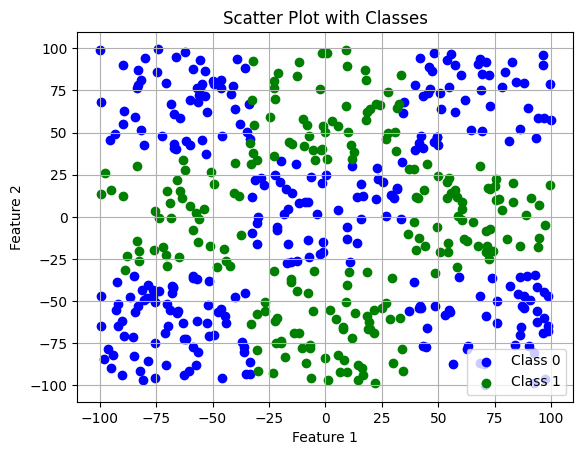

In [215]:
y_pred = net_x_3_soft.feedforward(X_test_x_3)
classes = np.argmax(y_pred, axis=1)
y_pred = classes
plot_scatter_with_classes(X_test_x_3, y_pred)

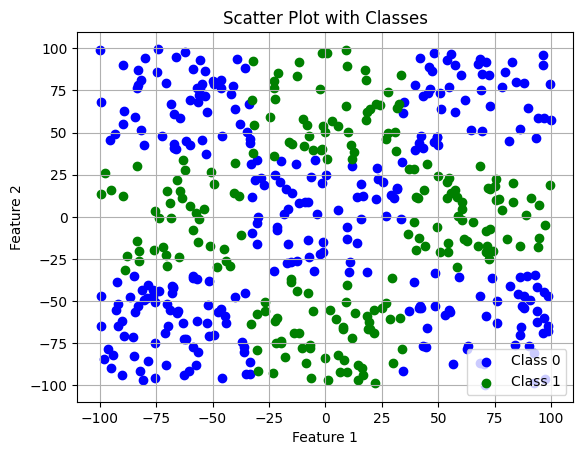

In [216]:
plot_scatter_with_classes(X_test_x_3, y_test_x_3)

In [217]:
net_x_3_sigm = Network([2,10,10,2], "sigmoid", problem="classification", last_layer_function="sigmoid")
net_x_3_sigm.generate_weights("he")
net_x_3_sigm.generate_biases("zeros")

In [218]:
net_x_3_sigm.train(X_train_x_3, y_train_x_3_enc, 100, 0.004, 5000, shuffle=True, X_test = X_test_x_3, Y_test=y_test_x_3_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 1 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 2 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 3 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 4 complete, Fscore: [0.         0.66666667], Fscore_mean: 0.3333333333333333
Epoch 5 complete, Fscore: [0.22145329 0.6835443 ], Fscore_mean: 0.45249879549735006
Epoch 6 complete, Fscore: [0.29526462 0.60530421], Fscore_mean: 0.4502844180619592
Epoch 7 complete, Fscore: [0.4434968  0.50847458], Fscore_mean: 0.4759856889884717
Epoch 8 complete, Fscore: [0.52529183 0.49794239], Fscore_mean: 0.511617107812525
Epoch 9 complete, Fscore: [0.46908316 0.53107345], Fscore_mean: 0.5000783009890017
Epoch 10 complete, Fscore: [0.58983051 0.4097561 ], Fscore_mean: 0.4997933030177759
Epoch 11 complete, Fscore: [0.43835616 0.56227758], Fscore_mean: 0.5003168722273679
Ep

In [219]:
cost_soft = make_df_of_costs(net_x_3_soft.cost_history)
cost_sigm = make_df_of_costs(net_x_3_sigm.cost_history)
cost_list = [(cost_soft, 'Softmax'), (cost_sigm, 'Sigmoid')]

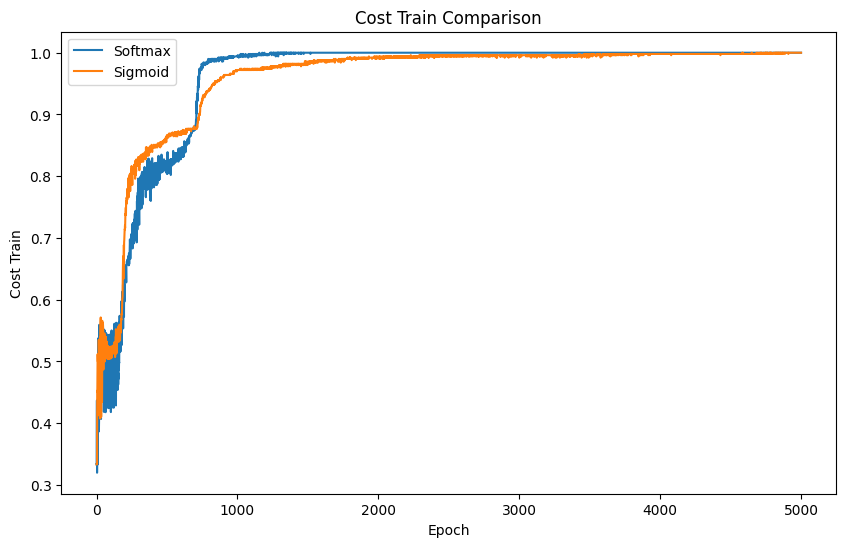

In [220]:
plot_multiple_costs(cost_list)

W tym przypadku, jak i w tym wyżej modele się wymieniają - raz lepiej radzi sobie model z funkcją softmax na końcu, a raz z sigmoidalną, jednak przez znacznie dłuższy czas lepiej radzi sobie funkcja softmax.

### Podsumowanie

W związku z tym, że w 3 rozpatrywanych zbiorach lepiej radzi sobie funkcja softmax, bądź radzi sobie podobnie jak sigmoidalna, to do klasyfikacji na ostatniej warstwie lepiej stosować funkcję softmax.